### Column integrated nudging tendencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import xarray as xr
import fsspec
import cftime
import intake
import vcm
import numpy as np

from vcm import  mass_integrate
from vcm.calc.thermo import column_integrated_heating_from_isochoric_transition, minus_column_integrated_moistening, latent_heat_vaporization
from fv3viz import plot_cube, mappable_var

N2F_TENDENCIES_PATH = "gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf/nudging_tendencies.zarr"
MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

def zonal_mean(
    ds: xr.Dataset, latitude: xr.DataArray, bins=np.arange(-90, 91, 2)
) -> xr.Dataset:
    zm = ds.groupby_bins(latitude, bins=bins).mean().rename(lat_bins="latitude")
    latitude_midpoints = [x.item().mid for x in zm["latitude"]]
    return zm.assign_coords(latitude=latitude_midpoints)


n2f_tendencies = intake.open_zarr(N2F_TENDENCIES_PATH).to_dask()

#### moist static energy nudging tendency $ \langle nQ_{MSE} \rangle =    \langle  nQ1 \rangle + L_{v}  \langle nQ2 \rangle$
$<nQ1>$ heating is for constant volume

In [29]:
Cp =  1004.
Rd = 287.05
Cv = Cp - Rd

def moist_static_energy_tendency(T: xr.DataArray, dQ1: xr.DataArray, dQ2: xr.DataArray): 
    return Cv * dQ1 + latent_heat_vaporization(T) * dQ2

#### nudged to fine wind tendencies are on the interfaces, need to center and rotate

In [4]:
from vcm.catalog import catalog
wind_rotation_matrix = catalog["wind_rotation/c48"].read()
grid=catalog["grid/c48"].read()

In [5]:
n2f_tendencies["dQu"], n2f_tendencies["dQv"] = vcm.cubedsphere.center_and_rotate_xy_winds(
    wind_rotation_matrix,
    n2f_tendencies["x_wind_tendency_due_to_nudging"],
    n2f_tendencies["y_wind_tendency_due_to_nudging"],
)

#### Need the pressure level thicknesses

In [7]:
n2f_state = intake.open_zarr("gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf/state_after_timestep.zarr").to_dask().sel(time=n2f_tendencies.time)
n2f_tendencies["pressure_thickness_of_atmospheric_layer"] = n2f_state["pressure_thickness_of_atmospheric_layer"]
n2f_tendencies["air_temperature"] = n2f_state["air_temperature"]

In [30]:
n2f_tendencies["column_integrated_dQv"] = mass_integrate(
    n2f_tendencies["dQv"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()


In [9]:

n2f_tendencies["column_integrated_dQu"] = mass_integrate(
    n2f_tendencies["dQu"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()
 
n2f_tendencies["column_integrated_dQv"] = mass_integrate(
    n2f_tendencies["dQv"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()


In [31]:
n2f_tendencies["column_integrated_heating_from_isochoric_transition"] = column_integrated_heating_from_isochoric_transition(
    n2f_tendencies["air_temperature_tendency_due_to_nudging"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
).mean("time").load()


In [32]:
n2f_tendencies["column_integrated_drying"] = minus_column_integrated_moistening(
    n2f_tendencies["specific_humidity_tendency_due_to_nudging"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
).mean("time").load()



In [33]:

n2f_tendencies["column_integrated_mse_tendency"] = mass_integrate(
    moist_static_energy_tendency(n2f_tendencies["air_temperature"], n2f_tendencies["air_temperature_tendency_due_to_nudging"], n2f_tendencies["specific_humidity_tendency_due_to_nudging"]),
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()
                      
       

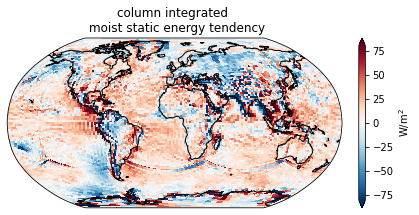

In [38]:

plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_mse_tendency"], grid]),
        "column_integrated_mse_tendency",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="W/m$^2$"
    
)
plt.title("column integrated \n moist static energy tendency")
plt.savefig("figures/nudging_column_int_nQmse_time_mean.png", bbox_inches = "tight")

#### Column integrated heating (isochoric transition- this is how it is reported in prognostic run diags)


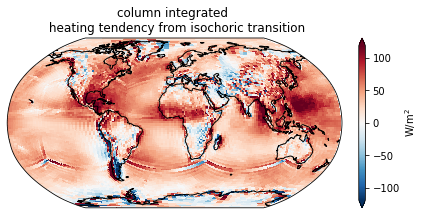

In [35]:
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_heating_from_isochoric_transition"], grid]),
        "column_integrated_heating_from_isochoric_transition",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="W/m$^2$"
    
)
plt.title("column integrated \n heating tendency from isochoric transition")
plt.savefig("figures/nudging_column_int_isochoric_heating_time_mean.png", bbox_inches = "tight")

#### Column integrated drying 

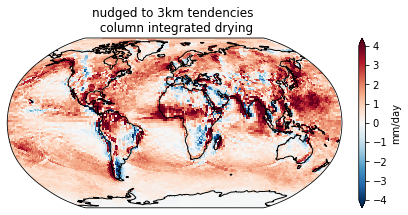

In [14]:
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_drying"], grid]),
        "column_integrated_drying",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="mm/day",
    vmax=4
    
)
plt.title("column integrated drying tendency")
plt.savefig("figures/nudging_column_int_drying_time_mean.png",bbox_inches = "tight")

#### Column integrated dQu [Pa]: Nudge to obs (top) vs nudge to fine (bottom)

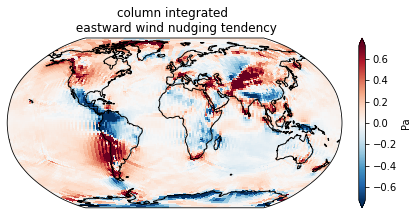

In [36]:
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_dQu"], grid]),
        "column_integrated_dQu",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="Pa"
    
)
plt.title("column integrated \n eastward wind nudging tendency")
plt.savefig("figures/nudging_column_int_eastwind_time_mean.png", bbox_inches = "tight")

#### dQu pressure level zonal mean time average

In [13]:
pressure_level_northward_wind = vcm.interpolate_to_pressure_levels(
         n2f_tendencies["dQv"], delp=n2f_tendencies["pressure_thickness_of_atmospheric_layer"], dim="z"
)

dQv_time_mean_zonal_pressure_level = zonal_mean(pressure_level_northward_wind, grid.lat).mean("time").load()

/home/AnnaK/fv3net/external/vcm/vcm/interpolate.py:147: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[field.dtype],
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


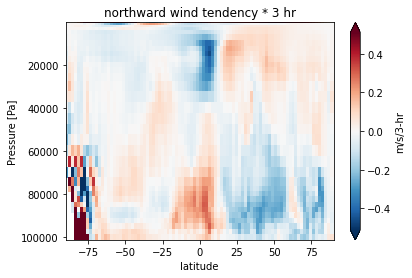

In [65]:
fig, ax = plt.subplots()
f = (
        dQv_time_mean_zonal_pressure_level * (3 * 3600)
    ).plot(robust=True, yincrease=False, )
plt.title("northward wind tendency * 3 hr")
ax.set_ylabel("Pressure [Pa]")
f.colorbar.set_label("m/s/3-hr")
plt.savefig("figures/nudging_zonal_pressure_northwind_tendency_time_mean.png", bbox_inches = "tight")


#### Composite figure

In [74]:
from cartopy import crs as ccrs

/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


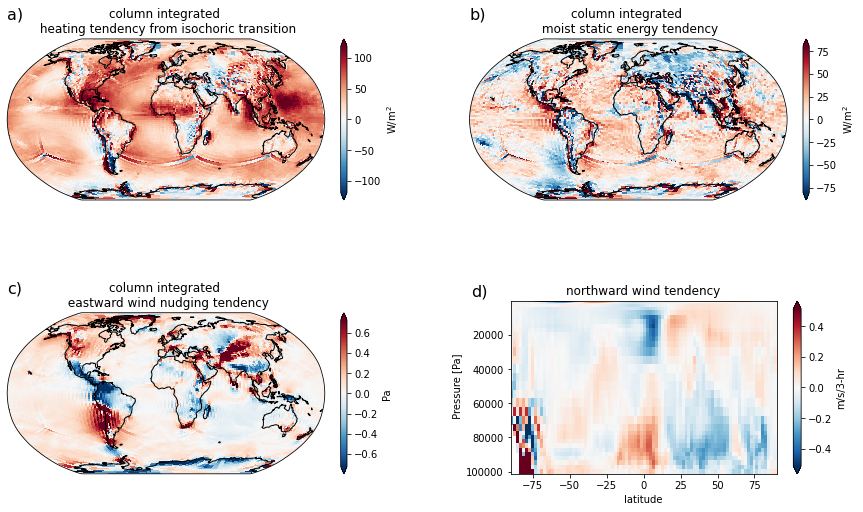

In [141]:

fig, axes = plt.subplots(2, 2, subplot_kw={"projection":ccrs.Robinson()}, figsize=(14, 8))

# a) heating
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_heating_from_isochoric_transition"], grid]),
        "column_integrated_heating_from_isochoric_transition",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="W/m$^2$",
    ax=axes[0][0],
    rasterized=True,
)
axes[0][0].set_title("column integrated \n heating tendency from isochoric transition")
axes[0][0].text(0.0, 1.2, "a)", va='top', fontsize=16, transform=axes[0][0].transAxes)


# b) MSE
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_mse_tendency"], grid]),
        "column_integrated_mse_tendency",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="W/m$^2$",
    ax=axes[0][1],
    rasterized=True
)
axes[0][1].set_title("column integrated \n moist static energy tendency")
axes[0][1].text(0.0, 1.2, "b)", va='top', fontsize=16, transform=axes[0][1].transAxes)


# c) eastward wind
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_dQu"], grid]),
        "column_integrated_dQu",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="Pa",
    ax=axes[1][0],
    rasterized=True
    
)
axes[1][0].set_title("column integrated \n eastward wind nudging tendency")
axes[1][0].text(0.0, 1.2, "c)", va='top', fontsize=16, transform=axes[1][0].transAxes)


# d) northward wind
axes[1][1].set_axis_off()

left = 0.625
bottom = 0.125
width = 0.33
height = 0.3
ax = fig.add_axes([left, bottom, width, height])

f = (
        dQv_time_mean_zonal_pressure_level * (3 * 3600)
    ).plot(robust=True, yincrease=False, ax=ax, rasterized=True)
ax.set_title("northward wind tendency")
ax.set_ylabel("\n \n \n Pressure [Pa]")
f.colorbar.set_label("m/s/3-hr")
ax.text(-0.15, 1.1, "d)", va='top', fontsize=16, transform=ax.transAxes)


fig.subplots_adjust(hspace=0.7, wspace=0.45)
plt.tight_layout()

plt.savefig("final_figures/composite_nudging_tendencies_col_int.pdf", bbox_inches = "tight")